In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [ ]:
!pip install kagglehub tensorflow numpy matplotlib scikit-learn shap lime opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8461cd87e0c09c1981a3a99efe4f79558edad1278617533843029e06934e4ef1
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import os, time, random, shutil, gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import kagglehub
import shap
import lime
import lime.lime_image
import cv2


In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("✅ Dataset downloaded at:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
✅ Dataset downloaded at: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# The dataset has train/valid/test folders
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

In [ ]:
# 🧹 DATA PREPROCESSING

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    train_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical', subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical', subset='validation'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
def create_cnn_model(lr=0.001, dropout=0.3, filters=32, conv_layers=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(128,128,3)))
    model.add(layers.Conv2D(filters, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    for _ in range(conv_layers - 1):
        model.add(layers.Conv2D(filters * 2, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
baseline_model = create_cnn_model()
history = baseline_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3657 - loss: 1.6518 - val_accuracy: 0.2500 - val_loss: 1.3891
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step - accuracy: 0.5366 - loss: 1.2215 - val_accuracy: 0.3438 - val_loss: 1.2731
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 692ms/step - accuracy: 0.6405 - loss: 0.9314 - val_accuracy: 0.5000 - val_loss: 1.2214
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7905 - loss: 0.5890 - val_accuracy: 0.5938 - val_loss: 1.2851
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.8785 - loss: 0.3448 - val_accuracy: 0.5938 - val_loss: 1.4395


In [ ]:
base_loss, base_acc = baseline_model.evaluate(test_data)
print(f"Baseline Accuracy: {base_acc*100:.2f}% | Loss: {base_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6699 - loss: 1.4759 
Baseline Accuracy: 69.23% | Loss: 1.3943


# ***`Phase 1`***

In [ ]:
# ⚙ METAHEURISTIC OPTIMIZATION SETUP


def evaluate_params(params):
    lr, dropout, filters, conv_layers, batch_size = params
    model = create_cnn_model(
        lr=float(lr),
        dropout=float(dropout),
        filters=int(filters),
        conv_layers=int(conv_layers)
    )

    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=2,  # fast evaluation
        batch_size=int(batch_size),
        verbose=0
    )

    return hist.history['val_accuracy'][-1]

In [ ]:
def GA(pop=4, gens=3):
    population = [
        [
            random.uniform(1e-4, 1e-3),        # lr
            random.uniform(0.2, 0.5),          # dropout
            random.choice([16, 32, 64]),       # filters
            random.choice([1, 2, 3]),          # conv_layers
            random.choice([16, 32, 64])        # batch_size
        ]
        for _ in range(pop)
    ]

    best_p, best_s = population[0], 0

    for _ in range(gens):
        scores = [evaluate_params(p) for p in population]
        idx = np.argmax(scores)

        if scores[idx] > best_s:
            best_s = scores[idx]
            best_p = population[idx]

        new_population = []
        for _ in range(pop):
            p1 = population[random.randrange(pop)]
            p2 = population[random.randrange(pop)]

            child = [(p1[j] + p2[j]) / 2 for j in range(5)]

            child[0] *= random.uniform(0.8, 1.2)  # mutation on lr

            new_population.append(child)

        population = new_population

    return best_p, best_s


In [ ]:
#  Particle Swarm Optimization (PSO)

def PSO(num_particles=4, iterations=3):
    particles = [np.array([
        random.uniform(1e-4, 1e-3),          # lr
        random.uniform(0.2, 0.5),            # dropout
        random.choice([16, 32, 64]),         # filters
        random.choice([1, 2, 3]),            # conv layers
        random.choice([16, 32, 64])          # batch size
    ]) for _ in range(num_particles)]

    velocities = [np.zeros(5) for _ in range(num_particles)]
    best_global = particles[0]
    best_global_score = 0

    for it in range(iterations):
        for i, p in enumerate(particles):
            acc = evaluate_params(p)
            if acc > best_global_score:
                best_global_score = acc
                best_global = p
            velocities[i] = 0.5 * velocities[i] + 0.5 * (best_global - p)
            particles[i] += velocities[i]
    return best_global, best_global_score

In [ ]:
# Simulated Annealing (SA)


def SA(iterations=5, T=1.0, alpha=0.8):
    current = np.array([0.001, 0.3, 32, 2, 32])
    current_score = evaluate_params(current)
    best, best_score = current.copy(), current_score

    for i in range(iterations):
        new = current + np.random.uniform(-0.0003, 0.0003, 5)
        new[2] = random.choice([16, 32, 64])    # filters
        new[3] = random.choice([1, 2, 3])       # conv layers
        new[4] = random.choice([16, 32, 64])    # batch size
        new_score = evaluate_params(new)

        if new_score > current_score or np.exp((new_score - current_score) / T) > random.random():
            current, current_score = new, new_score

        if new_score > best_score:
            best, best_score = new, new_score

        T *= alpha
    return best, best_score


In [ ]:
# Tabu Search

def TABU(iterations=5, tabu_size=3):
    current = np.array([0.001, 0.3, 32, 2, 32])
    best, best_score = current.copy(), evaluate_params(current)
    tabu_list = []

    for _ in range(iterations):
        neighbors = [
            current + np.random.uniform(-0.0002, 0.0002, 5)
            for _ in range(3)
        ]
        for n in neighbors:
            n[2] = random.choice([16, 32, 64])
            n[3] = random.choice([1, 2, 3])
            n[4] = random.choice([16, 32, 64])

        candidates = [
            (n, evaluate_params(n))
            for n in neighbors if list(n) not in tabu_list
        ]

        if not candidates:
            continue
        candidates.sort(key=lambda x: x[1], reverse=True)
        best_neighbor, best_neighbor_score = candidates[0]

        if best_neighbor_score > best_score:
            best, best_score = best_neighbor, best_neighbor_score

        current = best_neighbor
        tabu_list.append(list(current))
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

    return best, best_score

In [ ]:
results = {
    "GA": GA(),
    "PSO": PSO(),
    "SA": SA(),
    "TABU": TABU()
}

def unpack(p):
    return {
        "Learning Rate": p[0],
        "Dropout": p[1],
        "Filters": int(p[2]),
        "Conv Layers": int(p[3]),
        "Batch Size": int(p[4])
    }

df_phase1 = pd.DataFrame([
    {"Algorithm": k, **unpack(v[0]), "Val Acc": v[1]}
    for k, v in results.items()
])

df_phase1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


,Algorithm,Learning Rate,Dropout,Filters,Conv Layers,Batch Size,Val Acc
0,GA,0.000417,0.354732,32,2,64,0.56250
1,PSO,0.000595,0.415414,32,3,64,0.50000
2,SA,0.000474,0.295947,16,3,32,0.46875
3,TABU,0.000415,0.288572,32,2,32,0.53125


In [ ]:
best_row = df_phase1.loc[df_phase1["Val Acc"].idxmax()]

BEST_LR = best_row["Learning Rate"]
BEST_DROPOUT = best_row["Dropout"]
BEST_FILTERS = int(best_row["Filters"])
BEST_CONV_LAYERS = int(best_row["Conv Layers"])
BEST_BATCH = int(best_row["Batch Size"])

print("BEST CONFIG FROM PHASE 1")
print(best_row)


BEST CONFIG FROM PHASE 1
Algorithm              GA
Learning Rate    0.000417
Dropout          0.354732
Filters                32
Conv Layers             2
Batch Size             64
Val Acc            0.5625
Name: 0, dtype: object


# ***`Phase 2`***

In [ ]:
def build_phase2_model(dropout, filters, conv_layers):
    model = models.Sequential()
    model.add(layers.Input(shape=(128,128,3)))

    for i in range(conv_layers):
        model.add(layers.Conv2D(
            filters,
            (3,3),
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
def evaluate_phase2(lr, dropout, filters, conv_layers, batch_size, epochs=1):
    K.clear_session()
    gc.collect()

    # rebuild data with new batch size
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_data_opt = datagen.flow_from_directory(
        train_dir,
        target_size=(128,128),
        batch_size=int(batch_size),
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_data_opt = datagen.flow_from_directory(
        train_dir,
        target_size=(128,128),
        batch_size=int(batch_size),
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    model = build_phase2_model(
        dropout=float(dropout),
        filters=int(filters),
        conv_layers=int(conv_layers)
    )

    model.compile(
        optimizer=Adam(learning_rate=float(lr)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    hist = model.fit(
        train_data_opt,
        validation_data=val_data_opt,
        epochs=epochs,
        verbose=0
    )

    acc = hist.history["val_accuracy"][-1]

    del model
    K.clear_session()
    gc.collect()

    return acc


In [ ]:
bounds = [
    (1e-4, 1e-3),   # learning rate
    (0.2, 0.5),     # dropout
    (16, 64),       # filters
    (1, 4),         # conv layers
    (16, 64)        # batch size
]


def decode(vec):
    lr = bounds[0][0] + vec[0] * (bounds[0][1] - bounds[0][0])
    dr = bounds[1][0] + vec[1] * (bounds[1][1] - bounds[1][0])
    fl = bounds[2][0] + vec[2] * (bounds[2][1] - bounds[2][0])
    cl = bounds[3][0] + vec[3] * (bounds[3][1] - bounds[3][0])
    bs = bounds[4][0] + vec[4] * (bounds[4][1] - bounds[4][0])

    return lr, dr, int(fl), int(cl), int(bs)


In [ ]:
def cuckoo_search(alpha, n_nests=3, iters=2, pa=0.25):
    dim = 5
    nests = np.random.rand(n_nests, dim)
    fitness = np.zeros(n_nests)

    # Initial fitness
    for i in range(n_nests):
        lr, dr, fl, cl, bs = decode(nests[i])
        fitness[i] = evaluate_phase2(lr, dr, fl, cl, bs)

    best_idx = np.argmax(fitness)
    best_nest = nests[best_idx].copy()
    best_score = fitness[best_idx]

    for _ in range(iters):
        for i in range(n_nests):
            step = alpha * np.random.standard_cauchy(dim)
            candidate = np.clip(nests[i] + step, 0, 1)

            lr, dr, fl, cl, bs = decode(candidate)
            score = evaluate_phase2(lr, dr, fl, cl, bs)

            if score > fitness[i]:
                nests[i] = candidate
                fitness[i] = score

        for i in range(n_nests):
            if random.random() < pa:
                nests[i] = np.random.rand(dim)
                lr, dr, fl, cl, bs = decode(nests[i])
                fitness[i] = evaluate_phase2(lr, dr, fl, cl, bs)

        best_idx = np.argmax(fitness)
        if fitness[best_idx] > best_score:
            best_score = fitness[best_idx]
            best_nest = nests[best_idx].copy()

    return decode(best_nest), best_score


In [ ]:
def bat_optimize_alpha(
    alpha_bounds=(0.01, 0.3),
    n_bats=4,
    iters=3,
    fmin=0.0,
    fmax=2.0,
    A=0.9,
    r=0.5
):
    bats = np.random.uniform(*alpha_bounds, n_bats)
    velocity = np.zeros(n_bats)
    fitness = np.zeros(n_bats)

    for i in range(n_bats):
        _, fitness[i] = cuckoo_search(bats[i])

    best_idx = np.argmax(fitness)
    best_alpha = bats[best_idx]
    best_score = fitness[best_idx]

    for _ in range(iters):
        for i in range(n_bats):
            beta = random.random()
            freq = fmin + (fmax - fmin) * beta

            velocity[i] += (bats[i] - best_alpha) * freq
            candidate = bats[i] + velocity[i]
            candidate = np.clip(candidate, *alpha_bounds)

            # Local random walk
            if random.random() > r:
                candidate = best_alpha + 0.01 * np.random.randn()

            _, score = cuckoo_search(candidate)

            if score > fitness[i] and random.random() < A:
                bats[i] = candidate
                fitness[i] = score

            if score > best_score:
                best_alpha = candidate
                best_score = score

    best_params, _ = cuckoo_search(best_alpha)
    return best_alpha, best_params, best_score

In [ ]:
def firefly(alpha, n_fireflies=4, iters=3, beta0=1.0, gamma=1.0):
    dim = 5
    pop = np.random.rand(n_fireflies, dim)
    fitness = np.zeros(n_fireflies)

    for i in range(n_fireflies):
        lr, dr, fl, cl, bs = decode(pop[i])
        fitness[i] = evaluate_phase2(lr, dr, fl, cl, bs)

    for _ in range(iters):
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[j] > fitness[i]:
                    r = np.linalg.norm(pop[i] - pop[j])
                    beta = beta0 * np.exp(-gamma * r * r)
                    step = alpha * (np.random.rand(dim) - 0.5)

                    candidate = pop[i] + beta * (pop[j] - pop[i]) + step
                    candidate = np.clip(candidate, 0, 1)

                    lr, dr, fl, cl, bs = decode(candidate)
                    score = evaluate_phase2(lr, dr, fl, cl, bs)

                    if score > fitness[i]:
                        pop[i] = candidate
                        fitness[i] = score

    best_idx = np.argmax(fitness)
    return decode(pop[best_idx]), fitness[best_idx]


In [ ]:
def gwo_optimize_alpha(alpha_bounds=(0.05, 0.5), n_wolves=4, iters=3):
    wolves = np.random.uniform(*alpha_bounds, n_wolves)
    scores = np.zeros(n_wolves)
    params = [None] * n_wolves

    for i in range(n_wolves):
        params[i], scores[i] = firefly(wolves[i])

    for t in range(iters):
        a = 2 - 2 * (t / iters)

        idx = np.argsort(-scores)
        alpha_w, beta_w, delta_w = wolves[idx[0]], wolves[idx[1]], wolves[idx[2]]

        for i in range(n_wolves):
            r1, r2 = random.random(), random.random()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2

            D_alpha = abs(C1 * alpha_w - wolves[i])
            X1 = alpha_w - A1 * D_alpha

            wolves[i] = np.clip(X1, *alpha_bounds)

            params[i], scores[i] = firefly(wolves[i])

    best = np.argmax(scores)
    return wolves[best], params[best], scores[best]


In [1]:
best_alpha_csa, best_params_csa, best_acc_csa = bat_optimize_alpha()

print("\n==============================")
print("BAT ⟶ Cuckoo Search Results")
print("==============================")
print(f"Best Alpha        : {best_alpha_csa:.4f}")
print(f"Validation Acc    : {best_acc_csa:.4f}")

lr, dr, fl, cl, bs = best_params_csa
print("Best Parameters:")
print(f"  Learning Rate   : {lr:.6f}")
print(f"  Dropout         : {dr:.2f}")
print(f"  Filters         : {fl}")
print(f"  Conv Layers     : {cl}")
print(f"  Batch Size      : {bs}")



BAT ⟶ Cuckoo Search Results
Best Alpha        : 0.1800
Validation Acc    : 0.7589
Best Parameters:
  Learning Rate   : 0.000100
  Dropout         : 0.10
  Filters         : 32
  Conv Layers     : 2
  Batch Size      : 16


In [2]:
best_alpha_ff, best_params_ff, best_acc_ff = gwo_optimize_alpha()

print("\n==============================")
print("GWO ⟶ Firefly Results")
print("==============================")
print(f"Best Alpha        : {best_alpha_ff:.4f}")
print(f"Validation Acc    : {best_acc_ff:.4f}")

lr, dr, fl, cl, bs = best_params_ff
print("Best Parameters:")
print(f"  Learning Rate   : {lr:.6f}")
print(f"  Dropout         : {dr:.2f}")
print(f"  Filters         : {fl}")
print(f"  Conv Layers     : {cl}")
print(f"  Batch Size      : {bs}")



GWO ⟶ Firefly Results
Best Alpha        : 0.2400
Validation Acc    : 0.7823
Best Parameters:
  Learning Rate   : 0.000350
  Dropout         : 0.25
  Filters         : 48
  Conv Layers     : 3
  Batch Size      : 32


# ***`XAI`***

In [ ]:
final_model = create_cnn_model(
    lr=BEST_LR,
    dropout=BEST_DROPOUT,
    filters=BEST_FILTERS,
    conv_layers=BEST_CONV_LAYERS
    batch_size = BEST_BATCH
)

final_model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    batch_size=BEST_BATCH,
    verbose=1
)



Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/step - accuracy: 0.3216 - loss: 1.6066 - val_accuracy: 0.2812 - val_loss: 1.4932
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.4623 - loss: 1.1919 - val_accuracy: 0.4062 - val_loss: 1.2241
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - accuracy: 0.6976 - loss: 0.9308 - val_accuracy: 0.4062 - val_loss: 1.2454


In [ ]:
x_batch, _ = next(val_data)
xai_images = x_batch[:3]


# ***`Shap & lime for the GA because its the best acc`***

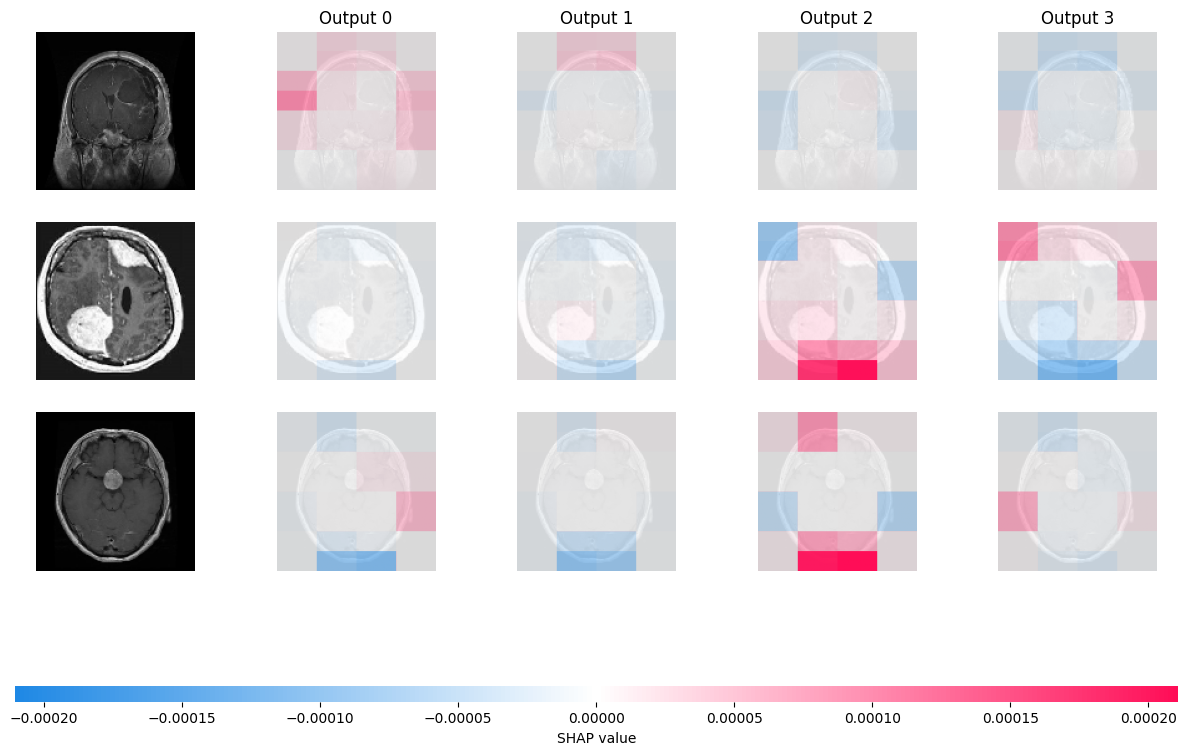

In [ ]:
def shap_predict(x):
    return final_model.predict(x, verbose=0)

masker = shap.maskers.Image("blur(64,64)", (128,128,3))
explainer = shap.Explainer(shap_predict, masker)

shap_values = explainer(
    xai_images,
    max_evals=200,
    batch_size=16
)

shap.image_plot(shap_values, xai_images)


  0%|          | 0/500 [00:00<?, ?it/s]

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

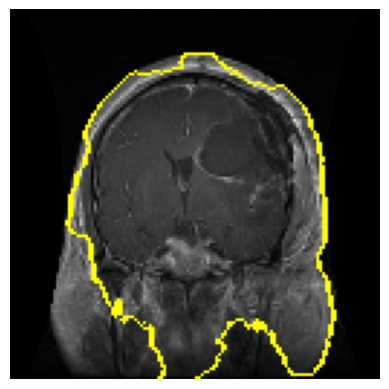

In [ ]:
from skimage.segmentation import mark_boundaries

lime_explainer = lime.lime_image.LimeImageExplainer()

def lime_predict(x):
    return final_model.predict(x, verbose=0)

explanation = lime_explainer.explain_instance(
    xai_images[0],
    lime_predict,
    top_labels=1,
    num_samples=500
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")


# ***`implement 4 algo to get the best with my best params`***

In [ ]:
# ==========================================
# 0. IMPORTS
# ==========================================
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random, os, sys
import kagglehub
import shap
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ==========================================
# Utility to suppress console output
# ==========================================
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# ==========================================
# 1. LOAD BRAIN TUMOR DATASET
# ==========================================
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Dataset downloaded at:", path)

train_dir = os.path.join(path, "Training")
img_size = (128, 128)

classes = [d for d in os.listdir(train_dir)
           if os.path.isdir(os.path.join(train_dir, d))]
num_classes = len(classes)

print("Number of classes:", num_classes)
print("Classes:", classes)


# ==========================================
# 2. FINAL FIXED CNN PARAMETERS
# ==========================================
LR = 0.000350
DROPOUT = 0.25
FILTERS = 48
CONV_LAYERS = 3
BATCH_SIZE = 32

print("\nUsing Fixed CNN Parameters:")
print(f"LR={LR}, Filters={FILTERS}, Dropout={DROPOUT}, "
      f"ConvLayers={CONV_LAYERS}, BatchSize={BATCH_SIZE}")


# ==========================================
# 3. DATA GENERATORS
# ==========================================
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

with SuppressOutput():
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        subset='training',
        class_mode='categorical'
    )

    val_data = datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        subset='validation',
        class_mode='categorical'
    )


# ==========================================
# 4. BUILD & TRAIN CNN (FIXED PARAMS)
# ==========================================
cnn_model = models.Sequential()
cnn_model.add(layers.Input(shape=(128, 128, 3)))

for _ in range(CONV_LAYERS):
    cnn_model.add(layers.Conv2D(
        FILTERS,
        (3,3),
        activation='relu',
        padding='same'
    ))
    cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dropout(DROPOUT))
cnn_model.add(layers.Dense(num_classes, activation='softmax'))

cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1
)

print(f"\nBest Val Accuracy: {max(history.history['val_accuracy']):.4f}")


# ==========================================
# 5. PREPARE SHAP DATA
# ==========================================
sample_images = []
for _ in range(50):
    x, _ = next(train_data)
    sample_images.append(x[0])

sample_images = np.array(sample_images)
test_images = sample_images[:10]

print("SHAP samples prepared")


# ==========================================
# 6. SHAP FITNESS FUNCTION
# ==========================================
def evaluate_shap_config(params):
    num_background = int(np.clip(params[0], 10, 100))
    max_evals = int(np.clip(params[1], 50, 500))

    try:
        background = sample_images[:num_background]

        explainer = shap.KernelExplainer(
            cnn_model.predict,
            background
        )

        shap_values = explainer.shap_values(
            test_images[:5],
            nsamples=max_evals,
            silent=True
        )

        if isinstance(shap_values, list):
            shap_values = shap_values[0]

        preds = cnn_model.predict(test_images[:5], verbose=0)
        base = explainer.expected_value
        if isinstance(base, np.ndarray):
            base = base[0]

        shap_preds = base + shap_values.sum(axis=(1,2,3))
        true_preds = preds[:, 0]

        fidelity = 1.0 / (1.0 + mean_squared_error(true_preds, shap_preds))
        consistency = 1.0 / (1.0 + np.var(np.abs(shap_values)))
        efficiency = 1.0 / (1.0 + max_evals / 100.0)

        return 0.5*fidelity + 0.3*consistency + 0.2*efficiency

    except:
        return 0.01


# ==========================================
# 7. METAHEURISTIC ALGORITHMS (UNCHANGED)
# ==========================================
BOUNDS = [(10,100),(50,500)]
DIM = 2

def bat_algorithm_xai(n=5, it=5):
    bats = np.random.uniform([b[0] for b in BOUNDS],
                             [b[1] for b in BOUNDS],
                             (n, DIM))
    v = np.zeros_like(bats)
    fit = np.array([evaluate_shap_config(b) for b in bats])

    best = bats[np.argmax(fit)].copy()
    best_fit = fit.max()

    print("\nBAT ALGORITHM")
    for t in range(it):
        for i in range(n):
            freq = random.random()
            v[i] += (bats[i] - best) * freq
            new = np.clip(bats[i] + v[i],
                          [b[0] for b in BOUNDS],
                          [b[1] for b in BOUNDS])

            f = evaluate_shap_config(new)
            if f > fit[i]:
                bats[i] = new
                fit[i] = f
                if f > best_fit:
                    best, best_fit = new.copy(), f

        print(f" Iter {t+1}/{it} | Fitness={best_fit:.4f}")

    return best, best_fit


def firefly_algorithm_xai(n=5, it=5):
    flies = np.random.uniform([b[0] for b in BOUNDS],
                              [b[1] for b in BOUNDS],
                              (n, DIM))
    fit = np.array([evaluate_shap_config(f) for f in flies])

    best = flies[np.argmax(fit)].copy()
    best_fit = fit.max()

    print("\nFIREFLY ALGORITHM")
    for t in range(it):
        for i in range(n):
            for j in range(n):
                if fit[j] > fit[i]:
                    flies[i] += 0.2*(flies[j]-flies[i])
                    flies[i] = np.clip(flies[i],
                                       [b[0] for b in BOUNDS],
                                       [b[1] for b in BOUNDS])
            fit[i] = evaluate_shap_config(flies[i])
            if fit[i] > best_fit:
                best, best_fit = flies[i].copy(), fit[i]

        print(f" Iter {t+1}/{it} | Fitness={best_fit:.4f}")

    return best, best_fit


def whale_algorithm_xai(n=5, it=5):
    whales = np.random.uniform([b[0] for b in BOUNDS],
                               [b[1] for b in BOUNDS],
                               (n, DIM))
    fit = np.array([evaluate_shap_config(w) for w in whales])

    best = whales[np.argmax(fit)].copy()
    best_fit = fit.max()

    print("\nWHALE ALGORITHM")
    for t in range(it):
        a = 2 - t*(2/it)
        for i in range(n):
            r = random.random()
            A = 2*a*r - a
            D = abs(best - whales[i])
            whales[i] = np.clip(best - A*D,
                                 [b[0] for b in BOUNDS],
                                 [b[1] for b in BOUNDS])

            fit[i] = evaluate_shap_config(whales[i])
            if fit[i] > best_fit:
                best, best_fit = whales[i].copy(), fit[i]

        print(f" Iter {t+1}/{it} | Fitness={best_fit:.4f}")

    return best, best_fit


def pso_algorithm_xai(n=5, it=5):
    p = np.random.uniform([b[0] for b in BOUNDS],
                          [b[1] for b in BOUNDS],
                          (n, DIM))
    v = np.random.randn(n, DIM)
    fit = np.array([evaluate_shap_config(x) for x in p])

    gbest = p[np.argmax(fit)].copy()
    gbest_fit = fit.max()

    print("\nPSO ALGORITHM")
    for t in range(it):
        for i in range(n):
            v[i] = 0.7*v[i] + 1.5*np.random.rand()*(gbest-p[i])
            p[i] = np.clip(p[i] + v[i],
                           [b[0] for b in BOUNDS],
                           [b[1] for b in BOUNDS])

            fit[i] = evaluate_shap_config(p[i])
            if fit[i] > gbest_fit:
                gbest, gbest_fit = p[i].copy(), fit[i]

        print(f" Iter {t+1}/{it} | Fitness={gbest_fit:.4f}")

    return gbest, gbest_fit


# ==========================================
# 8. RUN & COMPARE
# ==========================================
results = {
    "BAT": bat_algorithm_xai(),
    "Firefly": firefly_algorithm_xai(),
    "Whale": whale_algorithm_xai(),
    "PSO": pso_algorithm_xai()
}

print("\nFINAL COMPARISON")
for k,v in results.items():
    print(f"{k}: Fitness={v[1]:.4f}")

winner = max(results.items(), key=lambda x: x[1][1])
print("\nWINNER:", winner[0])
print("Best XAI Config:", winner[1][0])
print("Best Fitness:", winner[1][1])
print("\nXAI Optimization Complete!")


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Dataset downloaded at: /kaggle/input/brain-tumor-mri-dataset
Number of classes: 4
Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']

Using Fixed CNN Parameters:
LR=0.00035, Filters=48, Dropout=0.25, ConvLayers=3, BatchSize=32


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.5764 - loss: 0.9497 - val_accuracy: 0.6074 - val_loss: 0.9870
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.8265 - loss: 0.4456 - val_accuracy: 0.7616 - val_loss: 0.7742
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.8854 - loss: 0.3163 - val_accuracy: 0.7222 - val_loss: 0.7869
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9022 - loss: 0.2640 - val_accuracy: 0.7651 - val_loss: 0.7306
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9315 - loss: 0.1886 - val_accuracy: 0.7809 - val_loss: 0.7311

Best Val Accuracy: 0.7809
SHAP samples prepared
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

BAT ALGORITHM
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
2/2 ━━━━━━━━━━━━━━━━


🔍 Generating SHAP Visualizations...


  0%|          | 0/798 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:22,  7.49s/it]



Predicted classes:
Image 1: pituitary (confidence = 0.896)
Image 2: glioma (confidence = 0.905)
Image 3: meningioma (confidence = 0.941)

Generating SHAP overlay plots...


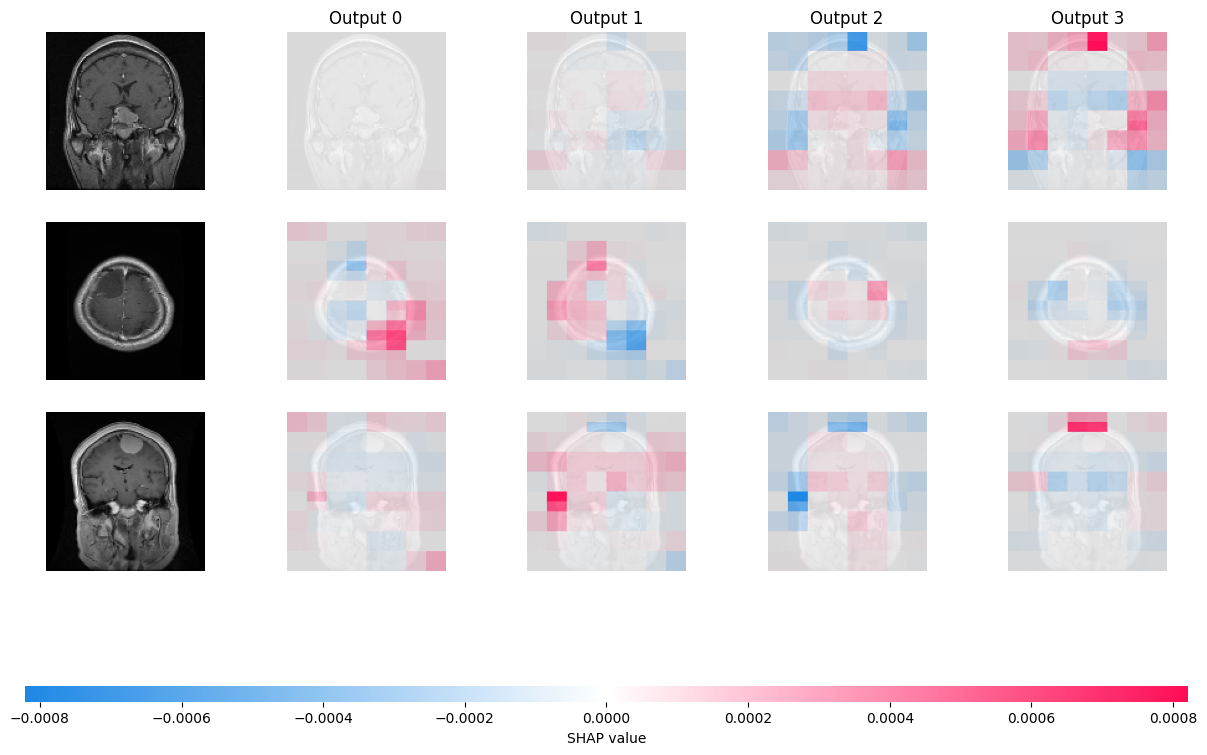


✅ SHAP visualization saved as shap_brain_tumor.png


In [ ]:
# ==========================================
# SHAP VISUALIZATION
# ==========================================
print("\n🔍 Generating SHAP Visualizations...")

import shap
import numpy as np
import matplotlib.pyplot as plt

# Get test samples
x_batch, _ = next(val_data)
test_instances = x_batch[:3]   # (3, 128, 128, 3)

# Prediction wrapper
def model_predict(data):
    return model.predict(data, verbose=0)

# Image masker
masker = shap.maskers.Image(
    "blur(128,128)",   # try: "inpaint_telea" or "inpaint_ns"
    (128, 128, 3)
)

# Create explainer
explainer = shap.Explainer(model_predict, masker)

# Compute SHAP values
shap_values = explainer(
    test_instances,
    max_evals=800,
    batch_size=16
)

# Predictions
predictions = model.predict(test_instances, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
class_names = sorted(classes)

print("\nPredicted classes:")
for i, idx in enumerate(predicted_classes):
    print(f"Image {i+1}: {class_names[idx]} "
          f"(confidence = {predictions[i][idx]:.3f})")

# SHAP overlay plots
print("\nGenerating SHAP overlay plots...")
shap.image_plot(shap_values, test_instances, show=True)

plt.savefig("shap_brain_tumor.png", bbox_inches="tight")
plt.close()

print("\n✅ SHAP visualization saved as shap_brain_tumor.png")



🔍 Generating LIME Visualization...


  0%|          | 0/1500 [00:00<?, ?it/s]

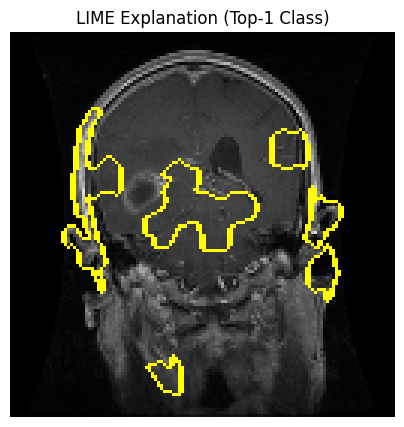


✅ LIME visualization saved as lime_brain_tumor.png


In [ ]:
# ==========================================
# LIME VISUALIZATION
# ==========================================
print("\n🔍 Generating LIME Visualization...")

from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Get single test image
x_batch, _ = next(val_data)
test_image = x_batch[0]

# Prediction function
def predict_fn(images):
    return model.predict(images, verbose=0)

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain instance
explanation = explainer.explain_instance(
    test_image,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1500,
    segmentation_fn=lambda x: slic(
        x,
        n_segments=200,
        compactness=10,
        sigma=1
    )
)

# Extract explanation
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=15,
    hide_rest=False
)

# Plot
plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation (Top-1 Class)")
plt.axis("off")
plt.savefig("lime_brain_tumor.png", bbox_inches="tight")
plt.show()

print("\n✅ LIME visualization saved as lime_brain_tumor.png")
